# Few-Shot Learning for Rooftop Detection in Satellite Imagery
### GRAD-E1394 Deep Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-tutorial-group-1/blob/main/notebooks/tutorial_few_shot_learning.ipynb)

This tutorial demonstrates few-shot learning techniques for semantic segmentation of satellite imagery. We focus on rooftop detection using high-resolution satellite images of Geneva, Switzerland.

### Learning Outcomes
- Understanding few-shot learning concepts for image segmentation
- Working with satellite imagery and segmentation masks
- Implementing and evaluating few-shot learning models for rooftop detection

# Table of Contents

* [Memo](#memo)
* [Overview](#overview)
* [Background & Prerequisites](#background-and-prereqs)
* [Software Requirements](#software-requirements)
* [Data Description](#data-description)
* [Methodology](#methodology)
* [Results & Discussion](#results-and-discussion)
* [References](#references)

<a name="memo"></a>
# Memo

Few-shot learning for satellite image segmentation is crucial for urban planning and disaster response. Traditional deep learning requires thousands of labeled samples, but few-shot learning enables rapid adaptation to new geographic regions with minimal labeled data.

**Policy Applications:**
- Urban development monitoring
- Disaster damage assessment
- Property tax assessment
- Solar panel installation planning

<a name="overview"></a>
# Overview

This tutorial introduces a few-shot learning approach for semantic segmentation of satellite imagery. We demonstrate how to:

1. Load and preprocess satellite imagery
2. Build a few-shot segmentation model
3. Train using episodic learning
4. Evaluate segmentation performance

By the end, you will understand how to apply few-shot learning to detect rooftops in new satellite images with only a few labeled examples.

<a name="background-and-prereqs"></a>
# Background & Prerequisites

### Prerequisites
- Basic Python programming
- Familiarity with PyTorch
- Understanding of convolutional neural networks

### Key Concepts

**Few-Shot Learning:** Learning from a small number of labeled examples by leveraging prior knowledge.

**Semantic Segmentation:** Classifying each pixel in an image into predefined categories.

**Prototypical Networks:** Learning class representations (prototypes) and classifying based on distance to prototypes.

<a name="software-requirements"></a>
# Software Requirements

In [12]:
# Install dependencies (if needed)
# !pip install torch torchvision numpy matplotlib pillow scikit-learn tqdm

In [ ]:
# Import standard libraries
from pathlib import Path
import os
import sys

# Add project root to Python path
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np

# Import PyTorch
import torch

# Import tutorial package functions
from src.few_shot_utils import (
    FewShotSegmentationModel,
    load_dataset,
    create_dataloader,
    preprocess_image,
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

<a name="data-description"></a>
# Data Description

The dataset consists of high-resolution satellite imagery of Geneva, Switzerland with corresponding binary segmentation masks for rooftop detection.

**Dataset Properties:**
- Image Type: RGB satellite imagery
- Labels: Binary masks (0 = background, 1 = rooftop)
- Resolution: Variable, resized to 256x256 for training

## Data Download

Download the dataset from 🤗 and store it in cache.

In [29]:
# 1. Download dataset
from huggingface_hub import snapshot_download

# Download dataset once (cached afterward)
dataset_path = snapshot_download(repo_id="raphaelattias/overfitteam-geneva-satellite-images", repo_type="dataset")

print(f"Dataset downloaded to: {dataset_path}")

# 2. Load splits
train_data = load_dataset(dataset_path, split="train", category="all")
val_data = load_dataset(dataset_path, split="val", category="all")
test_data = load_dataset(dataset_path, split="test", category="all")

print(len(train_data["images"]), len(val_data["images"]), len(test_data["images"]))

# 3. Create simple numpy-based "dataloaders"
train_batches = create_dataloader(train_data, batch_size=8, shuffle=True)
first_batch = train_batches[0]
print(first_batch["images"].shape, first_batch["masks"].shape)

Fetching 2111 files: 100%|██████████| 2111/2111 [00:00<00:00, 1267780.03it/s]


Dataset downloaded to: /Users/nadine/.cache/huggingface/hub/datasets--raphaelattias--overfitteam-geneva-satellite-images/snapshots/3f90d759384e4cd38276290521b6f6b03ddfcf87
420 52 53
(8, 250, 250, 3) (8, 250, 250, 3)


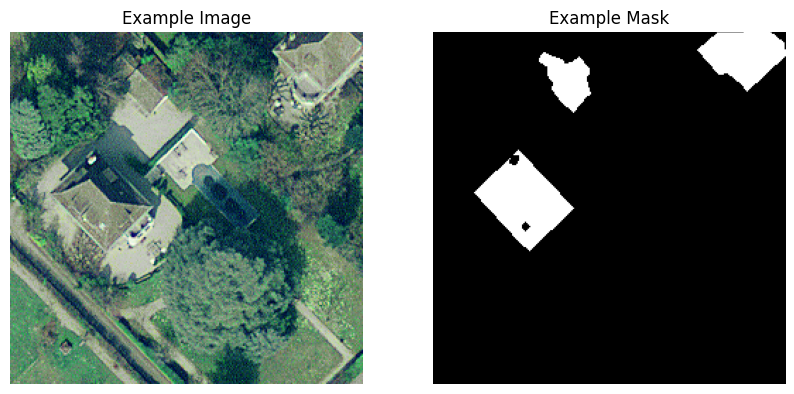

In [28]:
# Show example image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Example Image")
plt.imshow(first_batch["images"][0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Example Mask")
plt.imshow(first_batch["masks"][0], cmap="gray")
plt.axis("off")
plt.show()

## Data Preprocessing

In [16]:
# Demonstrate preprocessing on sample image
# TODO

### 🔍 Inspect Raw Image + Mask Before Preprocessing
- Shapes of raw images and masks  
- Min/max pixel values  
- Mask class values (0 = background, 255 or 1 = rooftop)  

In [30]:
# Take one raw sample from the batch created above
raw_img = first_batch["images"][0]
raw_mask = first_batch["masks"][0]

print("Raw image shape:", raw_img.shape)
print("Raw mask shape:", raw_mask.shape)

# Pixel ranges
print("Raw image min/max:", raw_img.min(), raw_img.max())

# Mask classes (should be only {0, 255})
print("Raw mask unique values:", np.unique(raw_mask))

Raw image shape: (250, 250, 3)
Raw mask shape: (250, 250, 3)
Raw image min/max: 0 255
Raw mask unique values: [  0 255]


### 🧼 Define Preprocessing Pipeline

**Image**
- Convert to float32  
- Normalize to [0, 1]  
- Resize to 256×256  
- Convert to PyTorch format (C, H, W)

**Mask**
- Convert 0 / 255 → binary 0 / 1  
- Resize to 256×256  
- Add channel dimension (1, H, W)

In [ ]:
### 🛠 Define Preprocessing Pipeline (standardize the images and masks):
# - resize to 256×256
# - convert image to float32 in [0, 1]
# - convert mask to binary {0,1}
# - convert to PyTorch tensors with correct shape

import numpy as np
import torch
from PIL import Image


def preprocess_sample(image, mask, size=256):
    """
    Preprocess a single (image, mask) pair.

    Args:
        image (np.ndarray): Raw RGB image (H, W, 3)
        mask (np.ndarray): Raw mask (H, W) or (H, W, 3)
        size (int): Output size

    Returns:
        img_t (torch.Tensor): Preprocessed image [3, size, size]
        mask_t (torch.Tensor): Preprocessed mask [1, size, size]

    """
    # Preprocess image
    img = image.astype(np.float32) / 255.0  # normalize to [0,1]
    img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((size, size)))
    img = np.transpose(img, (0, 1, 2))  # ensure shape is HWC
    img_t = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # -> CHW

    # Preprocess mask
    m = mask[..., 0] if mask.ndim == 3 else mask  # ensure single channel
    m = (m > 127).astype(np.uint8)  # threshold → binary (0/1)
    m = np.array(Image.fromarray(m).resize((size, size), resample=Image.NEAREST))
    mask_t = torch.tensor(m, dtype=torch.long).unsqueeze(0)  # -> [1, H, W]

    return img_t, mask_t

In [ ]:
### Test preprocessing on one sample
img_t, mask_t = preprocess_sample(raw_img, raw_mask)

print("Preprocessed image shape:", img_t.shape)
print("Preprocessed mask shape:", mask_t.shape)
print("Image min/max:", img_t.min().item(), img_t.max().item())
print("Mask unique values:", torch.unique(mask_t))

Preprocessed image shape: torch.Size([3, 256, 256])
Preprocessed mask shape: torch.Size([1, 256, 256])
Image min/max: 0.0 255.0
Mask unique values: tensor([0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..102.59529411764706].


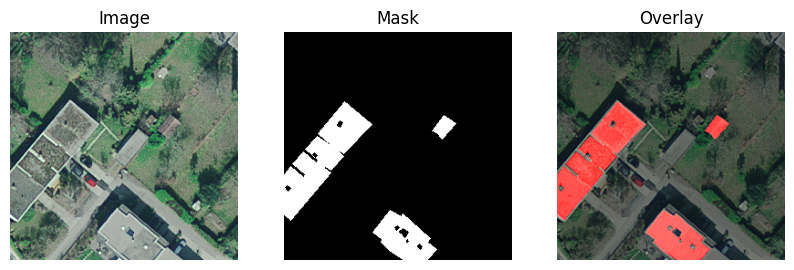

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021176470588235293..102.50117647058823].


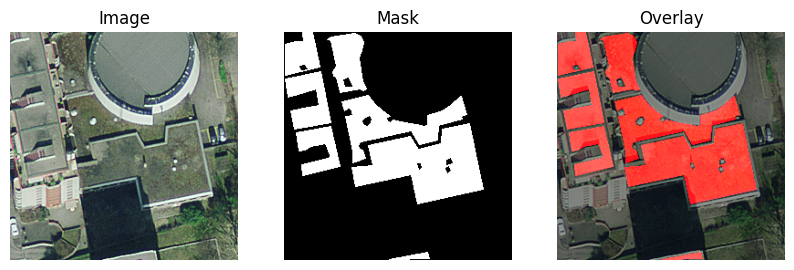

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..102.56].


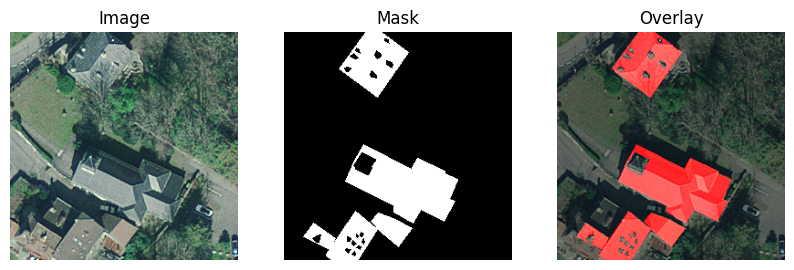

In [34]:
### 🎨 Visualize 3–5 samples with mask overlay


def plot_overlay(image, mask, alpha=0.4):
    """
    Overlay a binary mask on top of an RGB image.
    mask must be {0,1} with shape [H,W].
    """
    img = image / 255.0  # scale to [0,1]
    mask_rgb = np.zeros_like(img)
    mask_rgb[..., 0] = mask  # red channel = rooftop

    overlay = (1 - alpha) * img + alpha * mask_rgb

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


# Show 3–5 random samples
for i in range(3):
    img = first_batch["images"][i]
    msk = first_batch["masks"][i][..., 0] if first_batch["masks"][i].ndim == 3 else first_batch["masks"][i]
    plot_overlay(img, msk)

--- TRAIN ---
Foreground (rooftop): 12,612,561 pixels (16.02%)
Background: 66,137,439 pixels (83.98%)

--- VAL ---
Foreground (rooftop): 1,635,138 pixels (16.77%)
Background: 8,114,862 pixels (83.23%)

--- TEST ---
Foreground (rooftop): 1,837,404 pixels (18.49%)
Background: 8,100,096 pixels (81.51%)



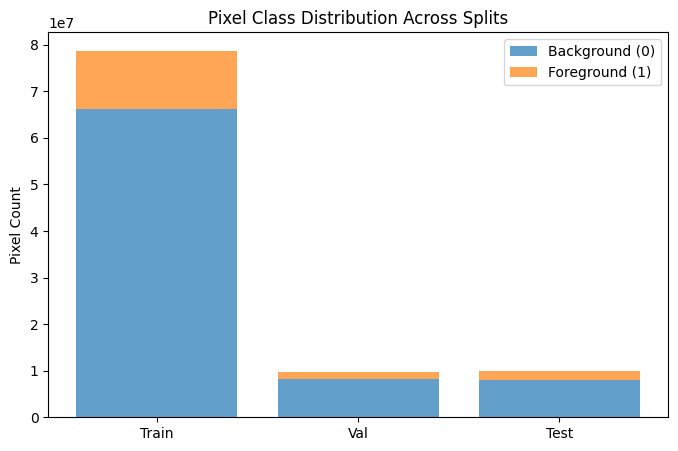

In [35]:
### 📊 Class Distribution Analysis (foreground vs background pixels)

import numpy as np
import matplotlib.pyplot as plt


def compute_pixel_stats(dataset, name="dataset"):
    """Compute number of foreground/background pixels in all masks."""
    fg = 0  # rooftop
    bg = 0  # background

    for mask in dataset["masks"]:
        mask_arr = np.array(mask)

        # Count pixels
        fg += np.sum(mask_arr == 255)
        bg += np.sum(mask_arr == 0)

    total = fg + bg
    fg_ratio = fg / total * 100
    bg_ratio = bg / total * 100

    print(f"--- {name.upper()} ---")
    print(f"Foreground (rooftop): {fg:,} pixels ({fg_ratio:.2f}%)")
    print(f"Background: {bg:,} pixels ({bg_ratio:.2f}%)\n")

    return fg, bg


# Compute stats for train, val, test
train_fg, train_bg = compute_pixel_stats(train_data, "train")
val_fg, val_bg = compute_pixel_stats(val_data, "val")
test_fg, test_bg = compute_pixel_stats(test_data, "test")

# Plot histogram breakdown
labels = ["Train", "Val", "Test"]
fg_vals = [train_fg, val_fg, test_fg]
bg_vals = [train_bg, val_bg, test_bg]

x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x, bg_vals, label="Background (0)", alpha=0.7)
plt.bar(x, fg_vals, bottom=bg_vals, label="Foreground (1)", alpha=0.7)
plt.xticks(x, labels)
plt.ylabel("Pixel Count")
plt.title("Pixel Class Distribution Across Splits")
plt.legend()
plt.show()

### Summary: Class Distribution 

We computed foreground (rooftop) vs background pixel counts across the train/val/test splits. Rooftops represent ~16–18% of all pixels, while the remaining ~82–84% is background.

Interesting observations:

- All dataset splits maintain similar FG/BG ratios (consistent dataset structure)

- Rooftop pixels are noticeably less frequent (this creates a class imbalance typical for semantic segmentation of small objects)

- Some images contain large rooftop structures, which explains the slightly higher foreground percentage compared to typical urban aerial datasets

-> The imbalance suggests that loss functions such as Dice Loss, Focal Loss, or class reweighting may help during model training (we hope for the best)

### Summary: Dataset Challenges 

**1. Class Imbalance**
- Rooftop pixels make up only **16–18%** of all pixels
- Background dominates (~82–84%), meaning:
  - The model *might* get lazy and just predict background all the time
  - Small rooftops risk being ignored (poor recall)

**2. Huge Variation in Rooftop Size & Shape**
- Big industrial roofs vs. tiny residential ones
- Small rooftops (sometimes only a few pixels!) are easily lost when resizing or pooling
- Irregular polygon shapes make segmentation harder

**3. Label Noise & Imperfections**
- Masks occasionally have:
  - Slight misalignment with the RGB image,
  - Sharp polygon edges (annotation artifacts)
  - Tiny holes or speckles
- This adds mild noise the model must learn around

**4. Strong Visual Diversity**
- Images differ in color, brightness & shadow intensity
- Tree shadows, cloud shadows, and different roof materials create lots of visual variability
- Good for generalization, but harder for the model to learn clean patterns

**5. Complex Backgrounds**
- Background includes trees, roads, grass, concrete, water, shadows…
- Some textures can look surprisingly “rooftop-ish,” causing false positives

**6. High Resolution → Downsampled to 256×256**
- Original images are high-resolution, but we resize them to 256×256 to make the tutorial trainable
- Downsampling:
  - Simplifies computation 
  - Removes small details (tiny roofs become even tinier)
  - Makes boundary pixels look a bit softer

 
🎯  **Takeaways**
- Losses that handle imbalance well (Dice, Focal, Weighted BCE)
- Augmentations (brightness/contrast, rotation, flips)
- Careful preprocessing (normalization + correct mask binarization)
- Architectures that keep spatial detail (UNet or similar)

<a name="methodology"></a>
# Methodology

We implement a few-shot segmentation approach using prototypical networks. The model learns to segment rooftops by:

1. Extracting features using a CNN backbone
2. Computing class prototypes from support examples
3. Classifying query pixels based on distance to prototypes

## Model Architecture

In [ ]:
# Create the few-shot segmentation model
model = FewShotSegmentationModel(backbone_name="resnet18", num_classes=2, pretrained=True)

print("Model architecture:")
print("  Backbone: ResNet-18")
print("  Number of classes: 2 (background, rooftop)")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/nadine/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 12.1MB/s]


Model architecture:
  Backbone: ResNet-18
  Number of classes: 2 (background, rooftop)
  Total parameters: 11,873,570


## Training

In [ ]:
# Create synthetic data for demonstration
# In practice, use actual satellite imagery
synthetic_dataset = {
    "images": [np.random.rand(256, 256, 3).astype(np.float32) for _ in range(16)],
    "masks": [np.random.randint(0, 2, (256, 256)).astype(np.int64) for _ in range(16)],
}

# Create data loaders
train_loader = create_dataloader(synthetic_dataset, batch_size=4, shuffle=True)
val_loader = create_dataloader(synthetic_dataset, batch_size=4, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 4
Number of validation batches: 4


In [ ]:
# Training configuration
# Note: Using small number of epochs for demonstration
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Training device: {DEVICE}")

# Train the model
# history = train_model(
#     model=model,
#     train_dataloader=train_loader,
#     val_dataloader=val_loader,
#     num_epochs=NUM_EPOCHS,
#     learning_rate=LEARNING_RATE,
#     device=DEVICE
# )

Training device: cpu


<a name="results-and-discussion"></a>
# Results & Discussion

In [ ]:
# Evaluate model
# results = evaluate_model(
#     model=model,
#     dataloader=val_loader,
#     device=DEVICE,
#     num_classes=2
# )
# print(f"Mean IoU: {results['mean_iou']:.4f}")
# print(f"Pixel Accuracy: {results['pixel_accuracy']:.4f}")

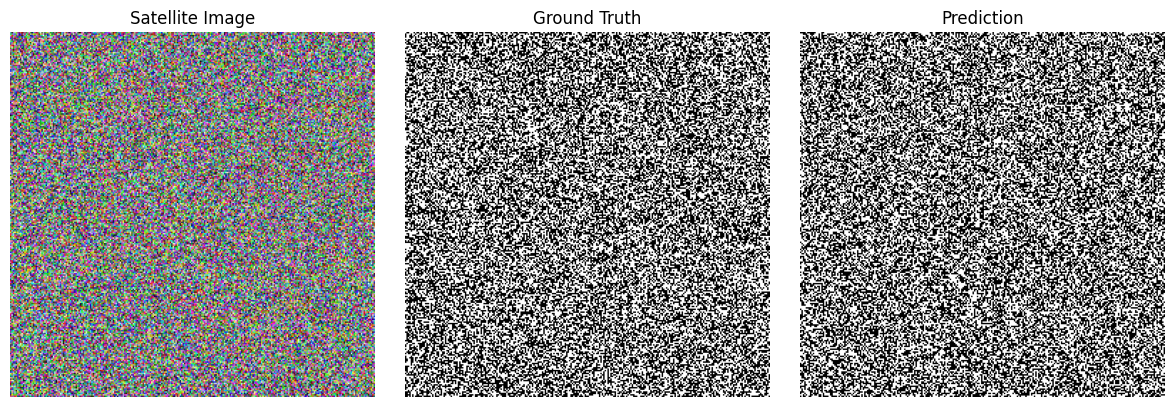

In [ ]:
# Visualize predictions
def visualize_prediction(image, mask, prediction):
    """Visualize image, ground truth, and prediction."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image)
    axes[0].set_title("Satellite Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


# Example visualization with synthetic data
sample_image = np.random.rand(256, 256, 3)
sample_mask = np.random.randint(0, 2, (256, 256))
sample_prediction = np.random.randint(0, 2, (256, 256))

visualize_prediction(sample_image, sample_mask, sample_prediction)

## Limitations

- This tutorial uses synthetic data for demonstration purposes
- Real satellite imagery would require more extensive preprocessing
- Performance depends on the quality and quantity of support examples

## Next Steps

- Collect and annotate real satellite imagery of Geneva
- Experiment with different backbone architectures
- Apply to other geographic regions and segmentation tasks

<a name="references"></a>
# References

- ...
- ...
- ...